In [1]:
import glob
import os
import re
from itertools import chain

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import mne
from mne.time_frequency import psd_multitaper
from mne.decoding import LinearModel
from mne.decoding import get_coef

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import lightgbm
from lightgbm import LGBMClassifier

from settings import EEGSettings

import random
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

from settings import EEGSettings
from

In [2]:
# path to data
path = '/Users/ilyamikheev/Documents/IHNA/eeg_data'

# create settings object and initialise montage
settings = EEGSettings(path=path)
montage = mne.channels.make_standard_montage(settings.montage_name)

In [73]:
# create features with events
subj_list_table, subj_list_features, e_list = [], [], []
for file_name in files:
    paths = glob.glob(path + '/{0}/Reals/*.edf'.format(file_name))
    epochs_list = []
    for event_ind in events_list:
        j = 0
        for i in [x for x in paths if '{0}'.format(event_ind) in x]: 
            event_id = dict(a=event_ind)
            raw = mne.io.read_raw_edf(i)
            if  len(raw.times)//500 < 10:
                continue  
            new_events = mne.make_fixed_length_events(raw, id=event_ind, start=5, duration=2, overlap=0)
            if j==1:
                epochs = mne.concatenate_epochs([mne.Epochs(raw, new_events, event_id = event_id, tmin=0, 
                                                            tmax=2, baseline=None, flat=dict(eeg=1e-20), 
                                                            preload=True), epochs])
            else:
                epochs = mne.Epochs(raw, new_events, event_id = event_id , tmin=0, tmax=2, baseline=None, 
                                    flat=dict(eeg=1e-20), preload=True)
                j+=1
        epochs_list.append(epochs.copy())
    for teta in range(len(epochs_list)):
            new_names = {}
            new_names = dict(
                    (ch_name,
                     ch_name.replace('-', '').replace('Chan ', 'E').replace('CAR', '').replace('EEG ', '')
                     .replace('CA', '').replace(' ', ''))
                     for ch_name in epochs_list[teta].ch_names)
            epochs_list[teta].rename_channels(new_names).set_montage(montage).drop_channels(chan_drop)
    e_list.append(epochs_list)
    feat_list, tabl_list = eeg_power_band(epochs_list)
    subj_list_table.append(tabl_list)
    subj_list_features.append(feat_list)
chan1 = epochs_list[0].ch_names

Extracting EDF parameters from /Users/ilyamikheev/Documents/IHNA/eeg_data/311_Strelchik_EEG_edf_class/Reals/Strelchik_311_01_rr_f3.5-40_eyesClean_new_split_n_21_m_241_t_254_eda_0_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Loading data for 17 events and 1001 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /Users/ilyamikheev/Documents/IHNA/eeg_data/311_Strelchik_EEG_edf_class/Reals/Strelchik_311_01_rr_f3.5-40_eyesClean_new_split_n_20_m_241_t_253_eda_0_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/ilyamikheev/Documents/IHNA/eeg_data/311_Strelchik_EEG_edf_class/Reals/Strelchik_311_04_rr_f3.5-40_eyesClean_new_split_n_22_m_241_t_254_eda_0_.edf...
EDF file detected
Setting channel info structure...
Creating raw

KeyboardInterrupt: 

In [ ]:
from lightgbm import LGBMClassifier

In [33]:
index_mat, index_not_mat = [indexes.index(i) for i in mat], [indexes.index(i) for i in not_mat]
new_mat = random.sample(mat, 10)
new_not_mat = random.sample(not_mat, 10)
index_mat, index_not_mat = [indexes.index(i) for i in new_mat], [indexes.index(i) for i in new_not_mat]
all_indexes = index_mat + index_not_mat

In [633]:
print(new_not_mat)

['333', '320', '319', '336', '331', '323', '313', '324', '325', '337']


In [15]:
# classification for each subject in both groups linear
coefs =  np.zeros((len(dict_cls), len(indexes),2,len(fr_bands),len(chan1)))
mean_fpr = np.linspace(0, 1, 100)
tprs_f, aucs_f = [], []
fpr_f, tpr_f = [], []

results = np.zeros((len(indexes),6))

k = 2
for i, key in enumerate(list(dict_cls.keys())):
    tprs = []
    aucs = []
    fprl = []
    tprl = []
# change to zip
    for subj in range(len(indexes)):
        ind = dict_cls[key]
        A, B = np.stack(subj_list_features[subj][ind[0]],axis=1), np.stack(subj_list_features[subj][ind[1]],axis=1)
        y = np.array([0]*A.shape[0] + [1]*B.shape[0])
        x = np.concatenate((A,B),axis=0)
        x_train, x_test, y_train, y_test = train_test_split(x.reshape(x.shape[0],-1),y,test_size=0.3)
        ac, auc, model, predictions = predict(x_train, x_test, y_train, y_test)
        results[subj,k-2:k] = (ac, auc)
        fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
        fprl.append(predictions)
        tprl.append(y_test)
        roc_auc = metrics.auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)
        for name, j in zip(['patterns_', 'filters_'],[0,1]):
            coef = get_coef(model, name, inverse_transform=True)
            coefs[i,subj,j,...] = coef.reshape(len(fr_bands),-1)
    k+=2
    tpr_f.append(tprl)
    fpr_f.append(fprl)
    tprs_f.append(tprs)
    aucs_f.append(aucs)

In [17]:
# evaluate mean and var for all subjects/and for subjects in groups
list_gr, ar_mean_var = [results,results[index_mat,...],results[index_not_mat,...]], np.zeros((3,12))
list_names_subj, list_names_fin = [], []
metr_name = ['accuracy','ROC/AUC']
for i, key in enumerate(list(dict_cls.keys())):
    ar_mean_var[i,...] = np.array(list(chain.from_iterable((a, b) for a,b in zip(list_gr[i].mean(axis=0),
                                                                                 list_gr[i].var(axis=0)))))
    list_names_subj.extend(['{} {}'.format(key,name) for name in metr_name])
    list_names_fin.extend(['{} {}'.format(key,name) for name in ['{} {}'.format(i,j) for i in metr_name
                                                                 for j in ['mean','var'] ]])

In [19]:
# save results to table
df_subj = pd.DataFrame(results, columns=list_names_subj, index=indexes)
df_fin = pd.DataFrame(ar_mean_var, columns=list_names_fin,
                       index=['all_subjects','mathematicians','not_mathematicians'])
writer = pd.ExcelWriter(os.path.join('/Users/ilyamikheev/Downloads/', 'subjects_classification_tasks_linear.xlsx'), engine='xlsxwriter')
df_subj.to_excel(writer, sheet_name='all_subj')
df_fin.to_excel(writer, sheet_name='mean_var')
writer.save()

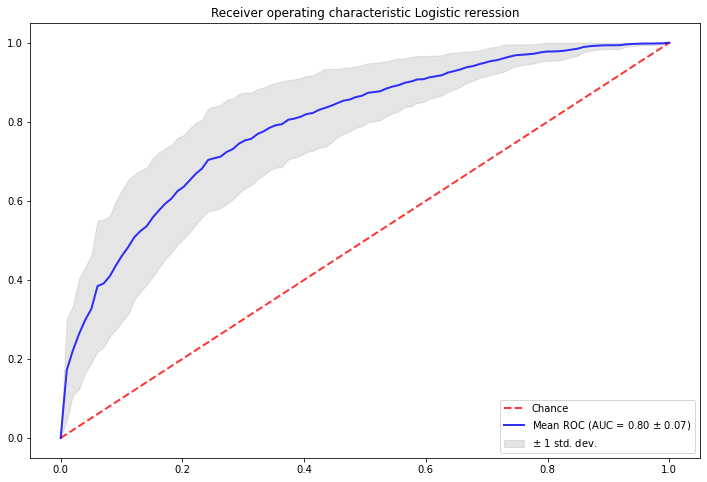

In [366]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

random_state = np.random.RandomState(0)

#tprs = tprs_f[2]
tprs  = [tprs_f[2][i] for i in index_not_mat]
#aucs = aucs_f[2]
aucs = [aucs_f[2][i] for i in index_not_mat]
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic Logistic reression",
)
ax.legend(loc="lower right")
plt.show()

/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhu

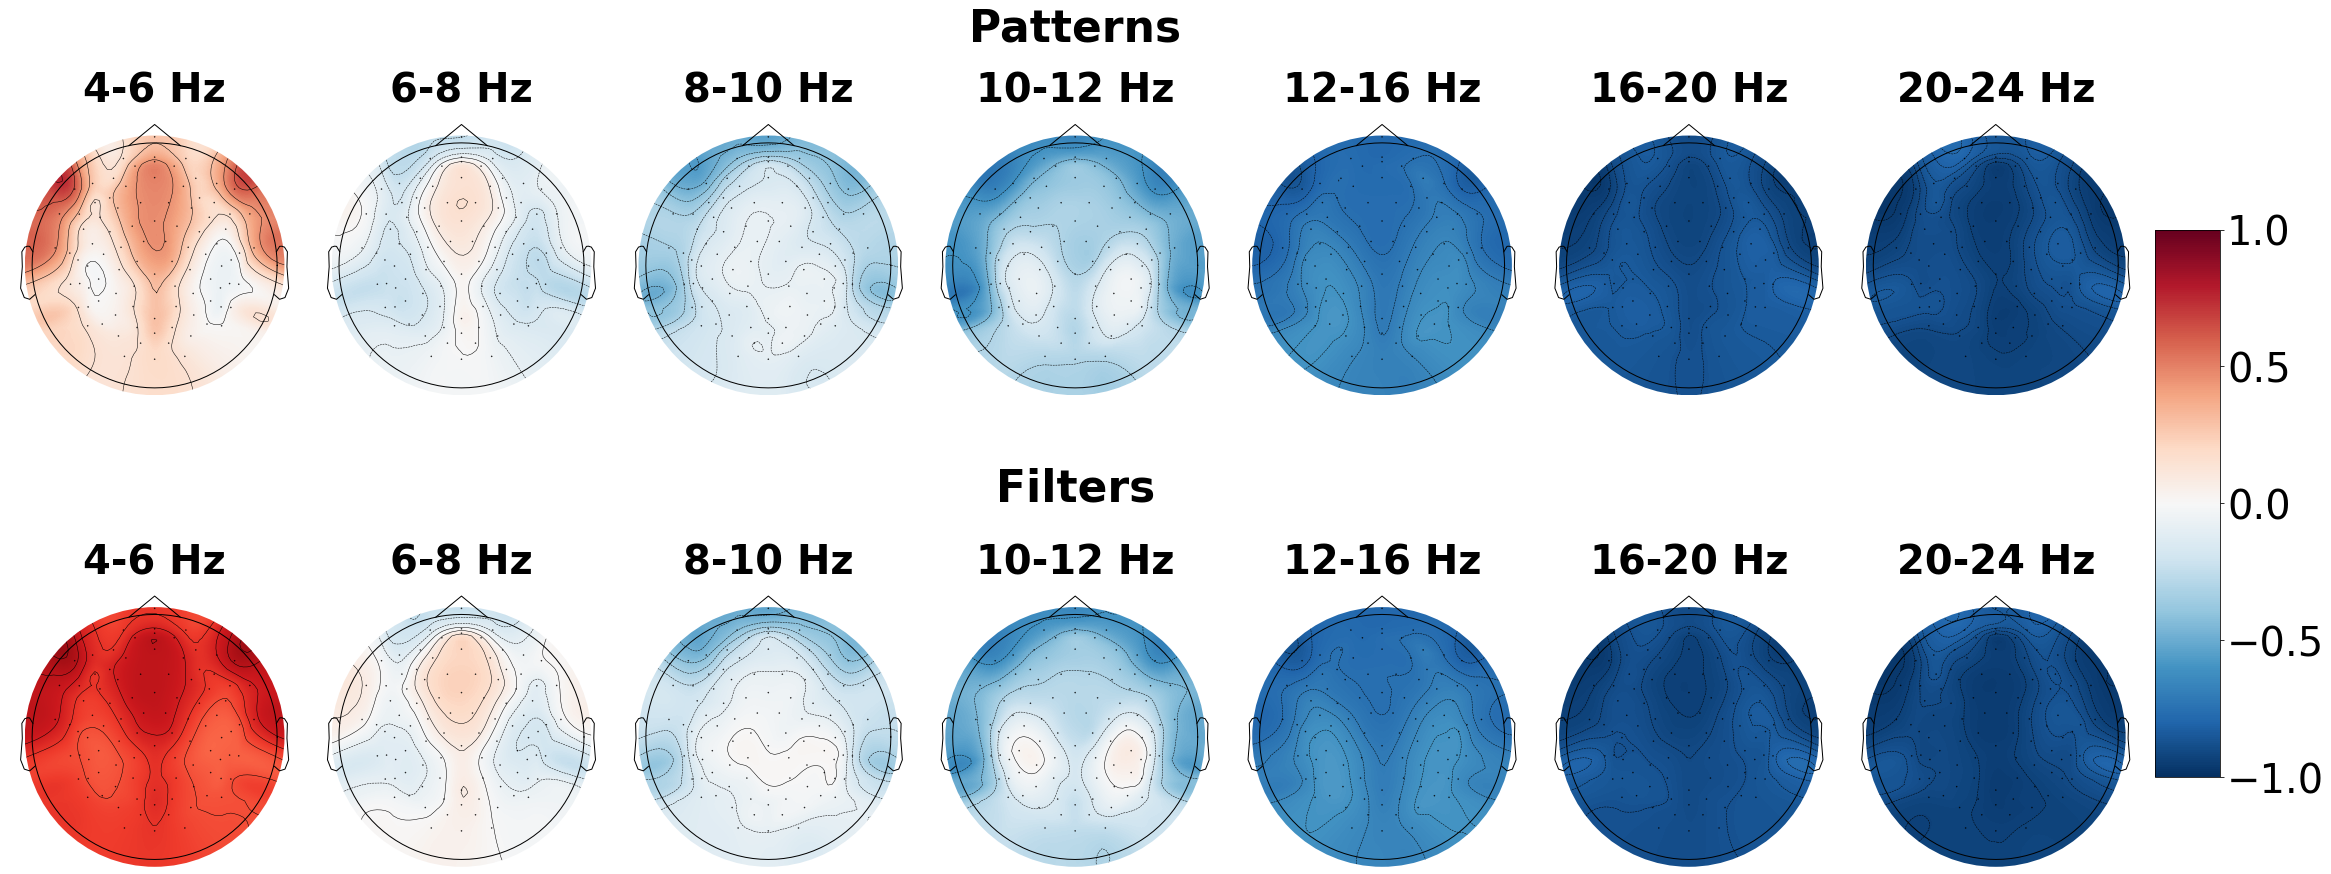

In [392]:
a_lf = []
s = coefs[0][0].shape
a_l = coefs[2][index_not_mat]
for i in range(len(index_not_mat)):
    k = minmax_scale(a_l[i].reshape(2,-1), feature_range=(-1,1), axis=1)
    a_lf.append(k.reshape(s))
fin_ar = np.mean(a_lf, axis=0)
fig = plot_patterns(fin_ar)

In [393]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'feature_patterns_241_242_not_mat.png'), format='png', bbox_inches='tight', dpi=600)

In [367]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'lr_roc_auc_241_242_not_mat.png'), format='png', bbox_inches='tight', dpi=600)

In [20]:
# classification for each subject in both groups lgb
mean_fpr = np.linspace(0, 1, 100)
tprs_f, aucs_f = [], []
fpr_f, tpr_f = [], []
ind = 0
im = []
results = np.zeros((len(indexes),6))
k = 2
for i, key in enumerate(list(dict_cls.keys())):
    im1 = []
    tprs = []
    aucs = []
    fprl = []
    tprl = []
    # change to zip
    for subj in range(len(indexes)):
        ind = dict_cls[key]
        A, B = np.stack(subj_list_features[subj][ind[0]], axis=1), np.stack(subj_list_features[subj][ind[1]], axis=1)
        y = np.array([0] * A.shape[0] + [1] * B.shape[0])
        x = np.concatenate((A, B), axis=0)
        x_train, x_test, y_train, y_test = train_test_split(x.reshape(x.shape[0], -1), y, test_size=0.3)
        lgb = LGBMClassifier(objective='binary')
        lgb.fit(x_train, y_train)
        feature_importances = (lgb.feature_importances_ / sum(lgb.feature_importances_)) * 100
        im1.append(feature_importances)
        predictions = lgb.predict_proba(x_test)
        auc = roc_auc_score(y_test, predictions[:,1])
        ac = balanced_accuracy_score(y_test, lgb.predict(x_test))
        results[subj,k-2:k] = (ac, auc)
        fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
        fprl.append(predictions)
        tprl.append(y_test)
        roc_auc = metrics.auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)
    k+=2
    im.append(im1)
    tpr_f.append(tprl)
    fpr_f.append(fprl)
    tprs_f.append(tprs)
    aucs_f.append(aucs)

In [21]:
# evaluate mean and var for all subjects/and for subjects in groups
list_gr, ar_mean_var = [results,results[index_mat,...],results[index_not_mat,...]], np.zeros((3,12))
list_names_subj, list_names_fin = [], []
metr_name = ['accuracy','ROC/AUC']
for i, key in enumerate(list(dict_cls.keys())):
    ar_mean_var[i,...] = np.array(list(chain.from_iterable((a, b) for a,b in zip(list_gr[i].mean(axis=0),
                                                                                 list_gr[i].var(axis=0)))))
    list_names_subj.extend(['{} {}'.format(key,name) for name in metr_name])
    list_names_fin.extend(['{} {}'.format(key,name) for name in ['{} {}'.format(i,j) for i in metr_name
                                                                 for j in ['mean','var'] ]])

In [22]:
# save results to table
df_subj = pd.DataFrame(results, columns=list_names_subj, index=indexes)
df_fin = pd.DataFrame(ar_mean_var, columns=list_names_fin,
                       index=['all_subjects','mathematicians','not_mathematicians'])
writer = pd.ExcelWriter(os.path.join('/Users/ilyamikheev/Downloads/', 'subjects_classification_tasks_lgb.xlsx'), engine='xlsxwriter')
df_subj.to_excel(writer, sheet_name='all_subj')
df_fin.to_excel(writer, sheet_name='mean_var')
writer.save()

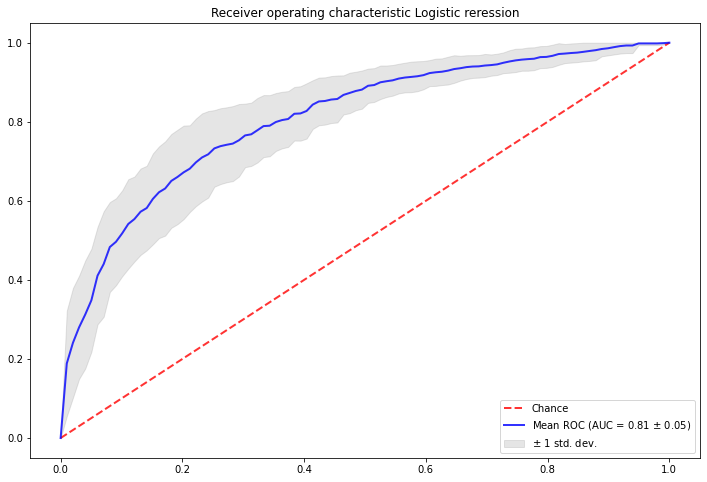

In [456]:
random_state = np.random.RandomState(0)
from sklearn.metrics import auc
#tprs = tprs_f[2]
tprs  = [tprs_f[2][i] for i in index_mat]
#aucs = aucs_f[2]
aucs = [aucs_f[2][i] for i in index_mat]
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic Logistic reression",
)
ax.legend(loc="lower right")
plt.show()

In [457]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'lgb_roc_auc_241_242_math_subj.png'), format='png', bbox_inches='tight', dpi=600)

/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhu

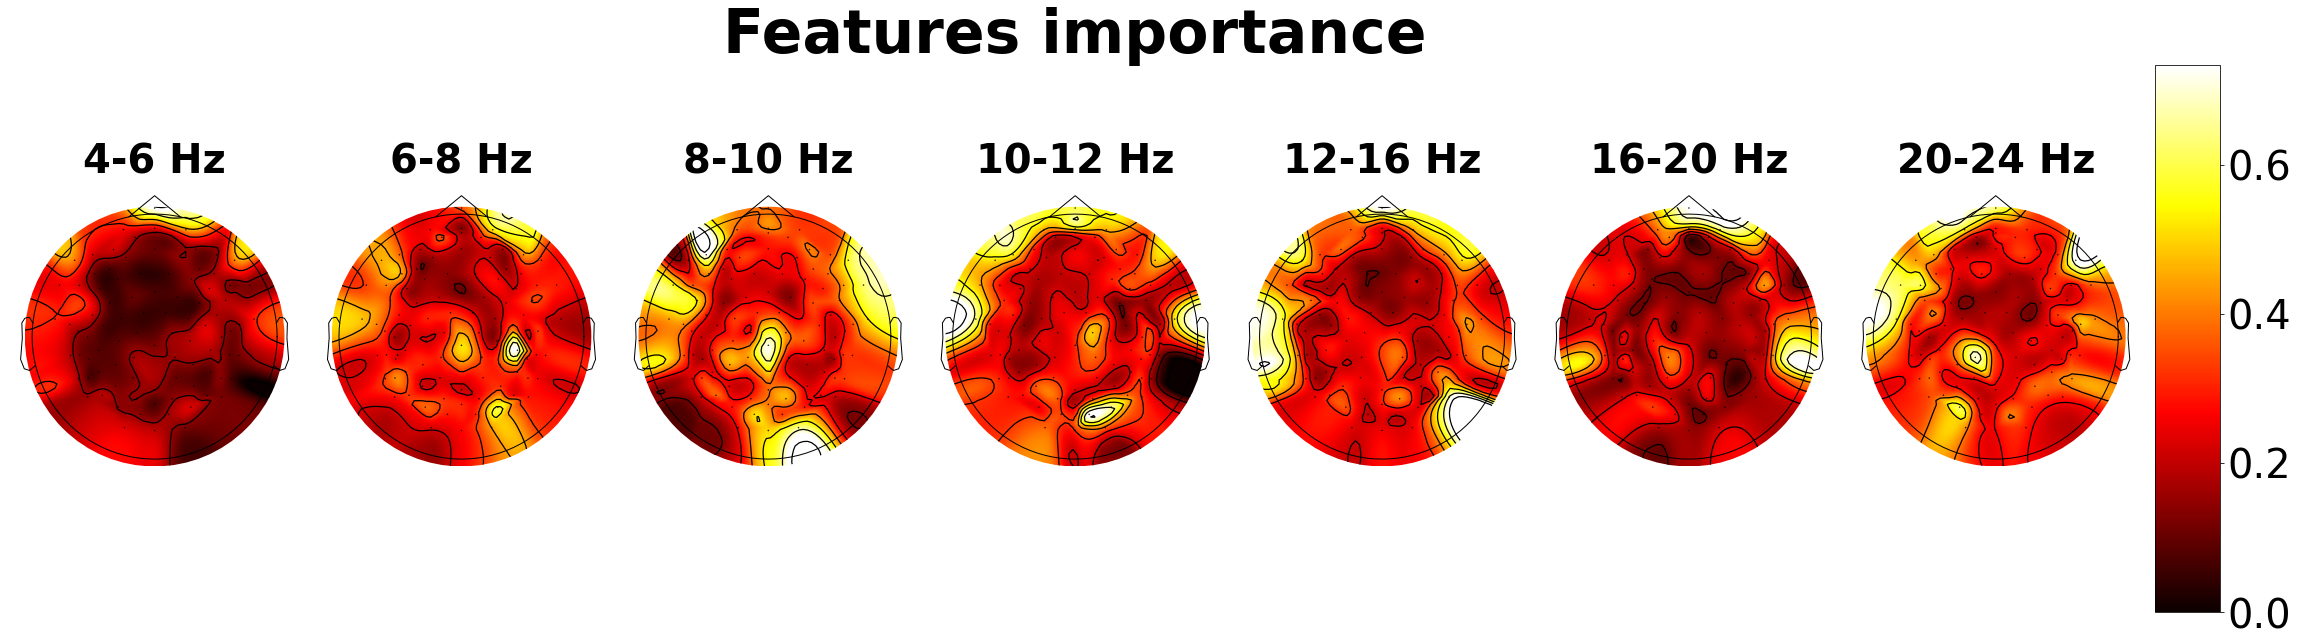

In [443]:
#a_lf = im[2]
a_lf = [im[2][i] for i in index_not_mat]
fin_ar = np.mean(a_lf, axis=0).reshape((7,95))
fig = plot_topo(fin_ar, info1)

In [444]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'feature_imp_241_242_not_mat.png'), format='png', bbox_inches='tight', dpi=600)

In [26]:
new_mat = ['326', '330', '316', '328', '314', '335', '327', '312', '317', '334']
new_not_mat = ['333', '320', '319', '336', '331', '323', '313', '324', '325', '337']
index_mat, index_not_mat = [indexes.index(i) for i in new_mat], [indexes.index(i) for i in new_not_mat]

In [70]:
# group linear model
import random
list_A, list_B = [], []
new_mat = ['311', '316', '312', '334', '313', '332', '324', '337']
new_not_mat = ['314','327','326','335','329','319', '318', '320']
index_mat, index_not_mat = [indexes.index(i) for i in new_mat], [indexes.index(i) for i in new_not_mat]
all_indexes = index_mat + index_not_mat
coefs_group = np.zeros((3,8,2,len(fr_bands),len(chan1)))
results_group_l = np.zeros((3,8,2))
#all_indexes_table = mat + not_mat
#all_indexes = np.array(all_indexes)
index_mat, index_not_mat = np.array(index_mat), np.array(index_not_mat)
tprs_f, aucs_f = [], []
fpr_f, tpr_f = [], []

for ind in range(3):
    tprs = []
    aucs = []
    fprl = []
    tprl = []
    for count, (s_ind_1, s_ind_2) in enumerate(zip(index_mat, index_not_mat)):
        A =  np.concatenate(([np.stack([subj_list_features[j] for j in index_mat[index_mat!=s_ind_1]][i][ind],axis = 1)
                          for i in range(index_mat[index_mat!=s_ind_1].shape[0])]),axis=0)
        B =  np.concatenate(([np.stack([subj_list_features[j] for j in index_not_mat[index_not_mat!=s_ind_2]][i][ind],axis = 1)
                          for i in range(index_not_mat[index_not_mat!=s_ind_2].shape[0])]),axis=0)
        C1 = np.stack(subj_list_features[s_ind_1][ind], axis = 1)
        C2 = np.stack(subj_list_features[s_ind_2][ind], axis = 1)
        x_train = np.concatenate((A,B),axis=0)
        y_train = [0]*A.shape[0] + [1]*B.shape[0]
        x_test = np.concatenate((C1, C2),axis=0)
        y_test = [0]*C1.shape[0] + [1]*C2.shape[0]
        x_train = x_train.reshape(x_train.shape[0],-1)
        x_test = x_test.reshape(x_test.shape[0],-1)
        # test size 0.2
        x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.1)
        ac, auc, model, predictions = predict(x_train, x_test, y_train, y_test)
        fpr, tpr, _ = roc_curve(y_test, predictions[:,0], pos_label=0)
        fprl.append(predictions)
        tprl.append(y_test)
        roc_auc = metrics.auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(roc_auc)
        for name, i in zip(['patterns_', 'filters_'],[0,1]):
            coef = get_coef(model, name, inverse_transform=True)
            coefs_group[ind,count,i,...] = coef.reshape(len(fr_bands),-1)
        results_group_l[ind,count, 0] = ac
        results_group_l[ind,count, 1] = auc
    tpr_f.append(tprl)
    fpr_f.append(fprl)
    tprs_f.append(tprs)
    aucs_f.append(aucs)


In [67]:
df_1 = pd.DataFrame(results_group_l[0,...], columns=['ac','auc'])
df_2 = pd.DataFrame(results_group_l[1,...], columns=['ac','auc'])
df_3 = pd.DataFrame(results_group_l[2,...], columns=['ac','auc'])
writer = pd.ExcelWriter(os.path.join('/Users/ilyamikheev/Downloads/', 'suc_not_suc_classification_tasks_linear.xlsx'), engine='xlsxwriter')
df_1.to_excel(writer, sheet_name='241')
df_2.to_excel(writer, sheet_name='242')
df_3.to_excel(writer, sheet_name='244')

writer.save()

In [69]:
df_1 = pd.DataFrame(results_group_t[0,...], columns=['ac','auc'])
df_2 = pd.DataFrame(results_group_t[1,...], columns=['ac','auc'])
df_3 = pd.DataFrame(results_group_t[2,...], columns=['ac','auc'])
writer = pd.ExcelWriter(os.path.join('/Users/ilyamikheev/Downloads/', 'suc_not_suc_classification_tasks_lgb.xlsx'), engine='xlsxwriter')
df_1.to_excel(writer, sheet_name='241')
df_2.to_excel(writer, sheet_name='242')
df_3.to_excel(writer, sheet_name='244')

writer.save()

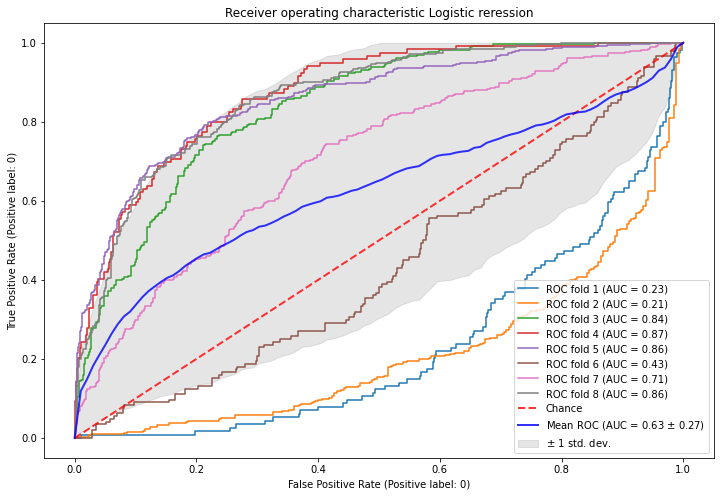

In [71]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

random_state = np.random.RandomState(0)

# Run classifier with cross-validation and plot ROC curves

tprs = tprs_f[2]
aucs = aucs_f[2]
fig, ax = plt.subplots(figsize=(12, 8))
for i, (tpr, fpr) in enumerate(zip(tpr_f[2], fpr_f[2])):
    viz = RocCurveDisplay.from_predictions(
        y_true=tpr,
        y_pred=fpr[:,0].tolist(),
        name=f"ROC fold {i+1}",
        pos_label = 0,
        ax=ax
    )
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic Logistic reression",
)
ax.legend(loc="lower right")
plt.show()

In [72]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'lgb_suc_not_suc_tasks.png'), format='png', bbox_inches='tight', dpi=600)

In [287]:
from itertools import compress
a_l = list(compress(im[1], results_group_t[1][:,1]>0.5))
fin_ar = np.mean(a_lf, axis=0).reshape((7,95))

In [288]:
fin_ar = np.mean(a_l, axis=0).reshape(len(fr_bands),len(chan1))

In [331]:
# for linear model
from itertools import compress
a_l = list(compress(coefs_group[2], results_group_l[2][:,1]>0.5))

In [298]:
a_l[0].shape

(2, 7, 95)

In [301]:
from sklearn.preprocessing import minmax_scale

minmax_scale(a_l[0].reshape(1,-1), feature_range=(-1,1), axis=1)

array([[ 1.        ,  0.74231743,  0.17894237, ..., -0.68543205,
        -0.68169395, -0.72068383]])

In [332]:
a_lf = []
s = a_l[0].shape
for i in range(len(a_l)):
    k = minmax_scale(a_l[i].reshape(2,-1), feature_range=(-1,1), axis=1)
    a_lf.append(k.reshape(s))
fin_ar = np.mean(a_lf, axis=0)

In [310]:
# for imp
fin_ar = np.mean(a_lf, axis=0).reshape((7,95))

ValueError: cannot reshape array of size 1330 into shape (7,95)

In [333]:
# for lm
fin_ar = np.mean(a_lf, axis=0)

In [318]:
fin_ar.min()

-0.9890094880110617

In [322]:
def plot_patterns(ar):
    #vmin = - np.amax(ar)
    #vmax = np.amax(ar)
    vmax = 1
    vmin = -1
    fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(30, 20))
    for name, pos, plot_name, ind in zip(('patterns_', 'filters_'),(0.82,0.5),
                                         ('Patterns','Filters'),(0,1)):
        for i,key in enumerate(list(fr_bands.keys())):
            a = mne.viz.plot_topomap(ar[ind,i,:],info,vmin=vmin,vmax=vmax, axes=axes[ind,i],
                                 show = False)
            axes[ind,i].set_title(label='{}-{} Hz'.format(*fr_bands[key]), fontdict = {'fontsize': 40, 'fontweight' : 'semibold'})
            mne.viz.tight_layout()
        plt.figtext(0.5,pos,'{}'.format(plot_name), va="center", ha="center", size=44, fontweight = 'semibold')
    m = cm.ScalarMappable(cmap='RdBu_r')
    m.set_array([vmin, vmax])
    cax = fig.add_axes([1, 0.3, 0.03, 0.38])
    cb = fig.colorbar(m, cax)
    cb.ax.tick_params(labelsize=40)
    return fig

/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhu

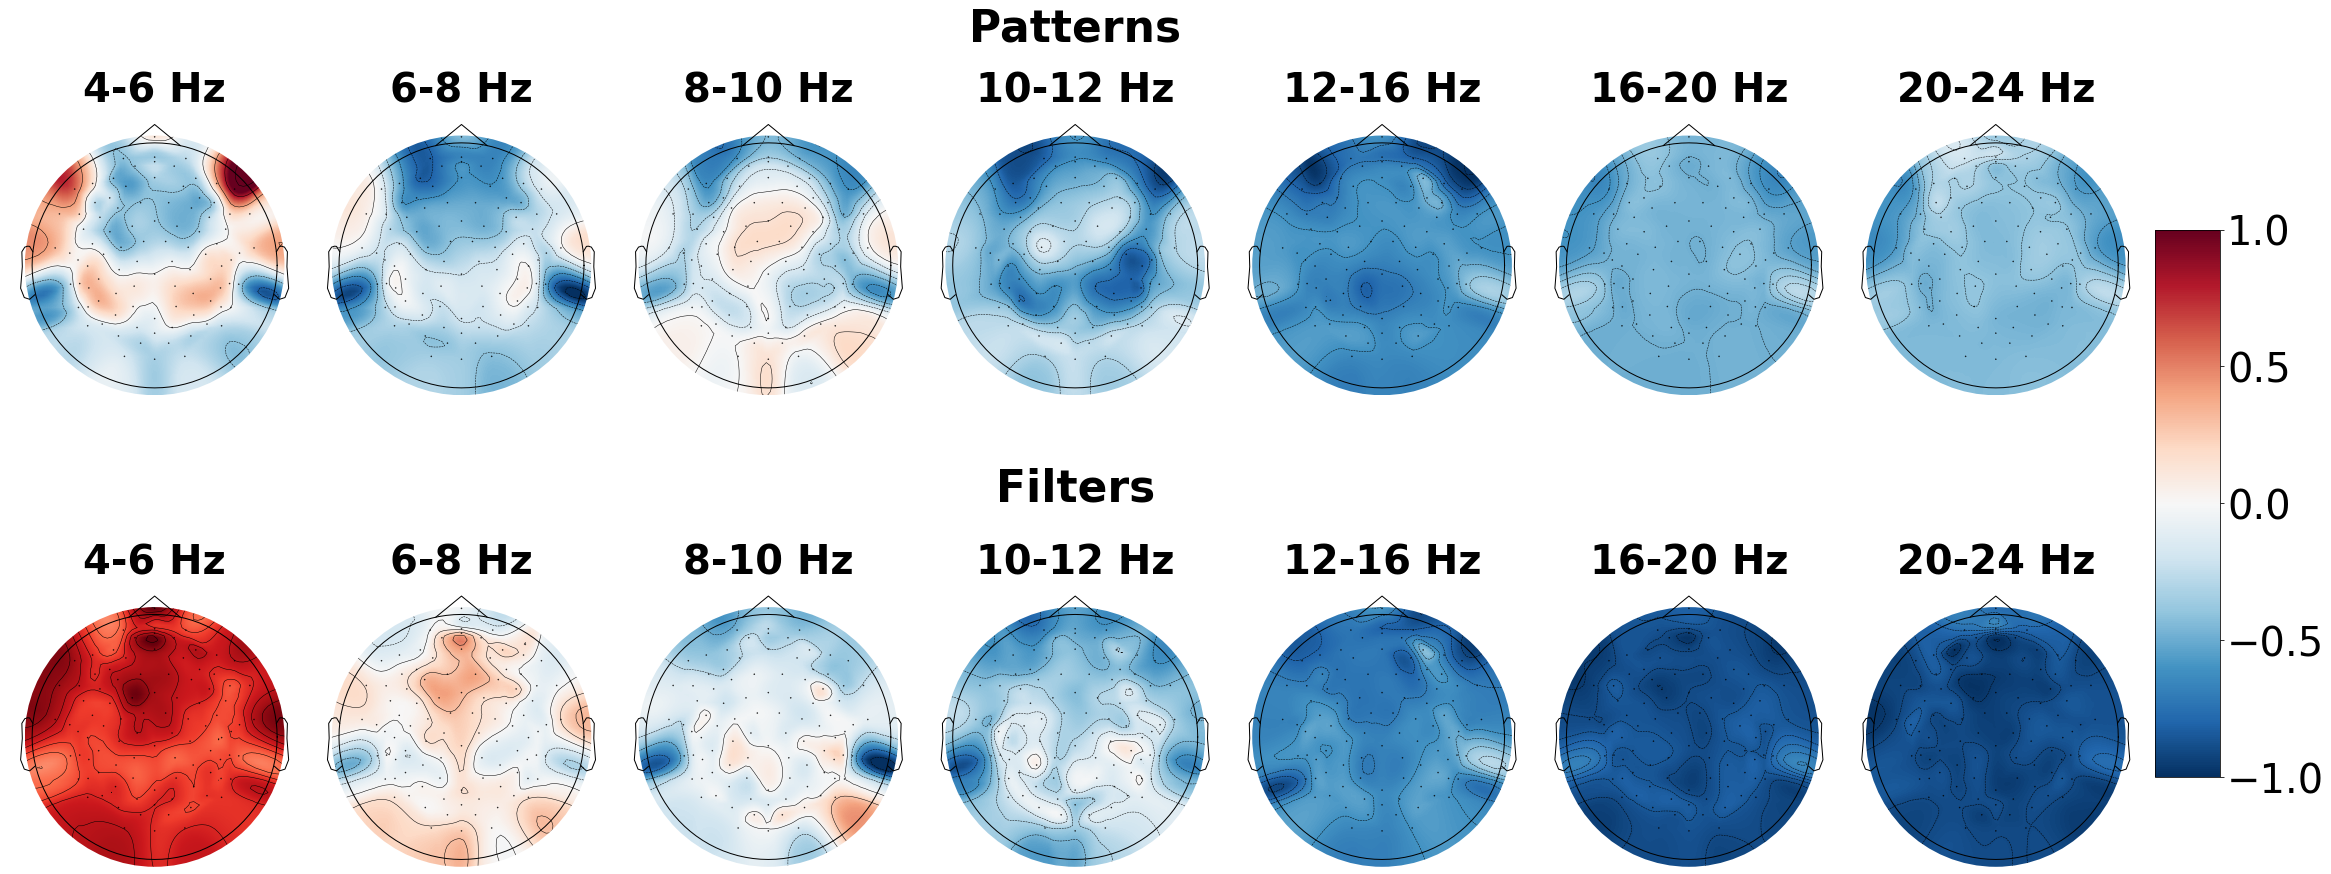

In [334]:
fig = plot_patterns(fin_ar)

In [335]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'feature_patterns_244_group.png'), format='png', bbox_inches='tight', dpi=600)

In [289]:
def plot_topo(ar, info):
    #vmin = np.amin(ar)
    vmin = 0
    vmax = np.amax(ar)
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(30, 20))
    ss = 0
    for i, key in enumerate(list(fr_bands.keys())):
        if i in range(7):
            evoked = mne.EvokedArray(ar[i,:].reshape(-1,1),
                             info, tmin=0.)
            a = evoked.plot_topomap(axes=axes[ss], time_format=None, colorbar = False,  times=[0], cmap='hot',
                                    size = 5, show_names = False, vmin = 0, show = False)
            axes[ss].set_title(label = '{}-{} Hz'.format(*fr_bands[key]), fontdict = {'fontsize': 40, 'fontweight' : 'semibold'})
            mne.viz.tight_layout()
            ss+=1
    m = cm.ScalarMappable(cmap='hot')
    m.set_array([vmin, vmax])
    cax = fig.add_axes([1, 0.3, 0.03, 0.38])
    cb = fig.colorbar(m, cax)
    cb.ax.tick_params(labelsize=40)
    plt.figtext(0.5, 0.7, '{}'.format('Features importance'), va="center", ha="center", size=60, fontweight = 'semibold')
    return fig

In [186]:
info = epochs_list[0].info
info1 = mne.create_info(info.ch_names, ch_types= 'eeg',
                        sfreq = 250)
info1.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E9, E10, E11, E12, E13, E15, E16, ...
 chs: 95 EEG
 custom_ref_applied: False
 dig: 98 items (3 Cardinal, 95 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 95
 projs: []
 sfreq: 250.0 Hz
>

In [ ]:
from scipy.spatial.qhull import Delaunay

/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhu

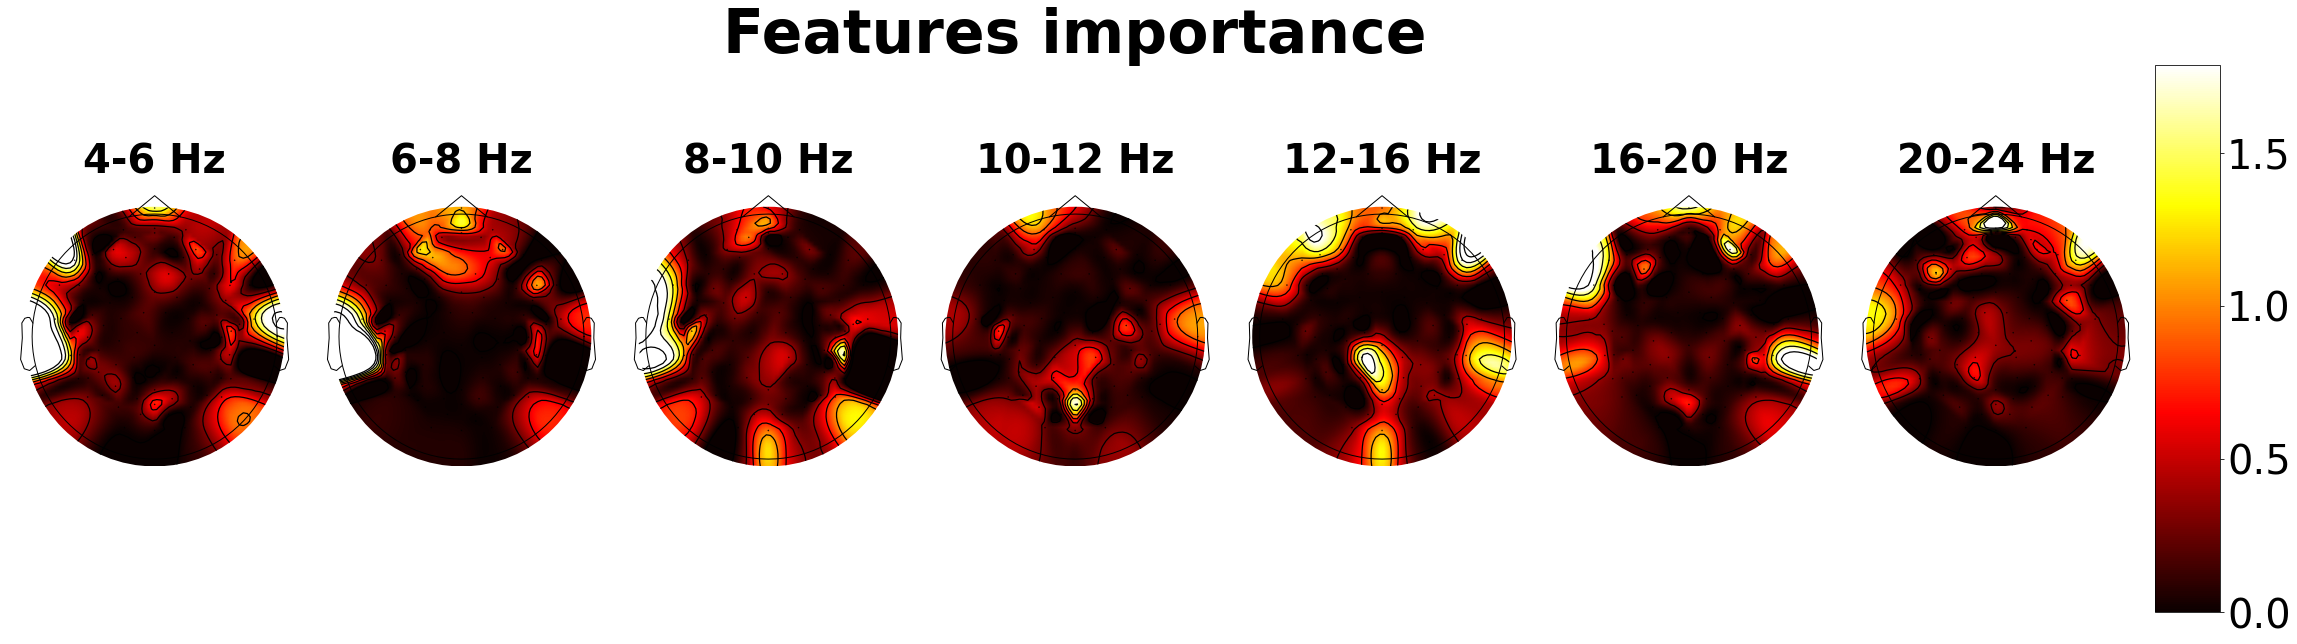

In [290]:
from matplotlib import cm
fig = plot_topo(fin_ar, info1)

In [ ]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'feature_imp_242_hot.png'), format='png', bbox_inches='tight', dpi=600)
#plt.save(os.path.join(path_subj_topo, 'cluster_test_244_fin_3.png'), format='png', dpi=600)
plt.close(fig)

In [42]:
len(index_not_mat)

14

In [ ]:
# classification using all subjects in both groups and all subjects linear
index_mat_n, index_not_mat_n = index_mat, index_not_mat
results_all, coefs_all = [], []
list_of_len = [len(indexes), len(index_mat), len(index_not_mat)]

tprs_f, aucs_f = [], []
fpr_f, tpr_f = [], []
for group_ind, subj_type in enumerate([[*range(len(indexes))],index_mat,index_not_mat]):
    subj_type = np.array(subj_type)
    results_sgroup = np.zeros((list_of_len[group_ind], 6))
    coefs_group_s = np.zeros((len(dict_cls),list_of_len[group_ind],2,len(fr_bands),len(chan1)))
    for i, key in enumerate(list(dict_cls.keys())):
        ind = dict_cls[key]
        tprs = []
        aucs = []
        fprl = []
        tprl = []
        for count, p in enumerate(subj_type): 
            A = np.concatenate(([np.stack([subj_list_features[j] for j in subj_type[subj_type!=p]][it][ind[0]],axis = 1) 
                                for it in range((subj_type.shape[0])-1)]),axis=0)
            B = np.concatenate(([np.stack([subj_list_features[j] for j in subj_type[subj_type!=p]][it][ind[1]],axis = 1) 
                                for it in range(subj_type.shape[0]-1)]),axis=0)
            C1 = np.stack(subj_list_features[p][ind[0]],axis = 1) 
            C2 = np.stack(subj_list_features[p][ind[1]],axis = 1)
            x_train = np.concatenate((A,B),axis=0)
            y_train = [0]*A.shape[0] + [1]*B.shape[0] 
            x_test = np.concatenate((C1, C2), axis=0)
            y_test = [0]*C1.shape[0] + [1]*C2.shape[0]  
            x_train = x_train.reshape(x_train.shape[0],-1)
            x_test = x_test.reshape(x_test.shape[0],-1)
            x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.1)
            ac, auc, model, predictions = predict(x_train, x_test, y_train, y_test)
            fpr, tpr, _ = roc_curve(y_test, predictions[:,0], pos_label=0)
            fprl.append(predictions)
            tprl.append(y_test)
            roc_auc = metrics.auc(fpr, tpr)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(roc_auc)
            for name, i1 in zip(['patterns_', 'filters_'],[0,1]):
                coef = get_coef(model, name, inverse_transform=True)
                coefs_group_s[i,count,i1,...] = coef.reshape(len(fr_bands),-1)
            results_sgroup[count, i] = ac
            results_sgroup[count, i+3] = auc
        tpr_f.append(tprl)
        fpr_f.append(fprl)
        tprs_f.append(tprs)
        aucs_f.append(aucs)
    coefs_all.append(coefs_group_s)
    results_all.append(results_sgroup)

In [ ]:
results_all[2].shape

(14, 6)

In [61]:
index_not_mat

[2, 7, 8, 9, 10, 11, 12, 13, 17, 19, 20, 21, 24, 25]

In [62]:
#df_1 = pd.DataFrame(results_all[0], columns=list_names_subj, index=indexes)
#df_2 = pd.DataFrame(results_all[1], columns=list_names_subj, index=index_mat)
#df_3 = pd.DataFrame(results_all[2], columns=list_names_subj, index=index_not_mat)
writer = pd.ExcelWriter(os.path.join('/Users/ilyamikheev/Downloads/', 'cross_subjects_classification_tasks_linear.xlsx'), engine='xlsxwriter')
df_1.to_excel(writer, sheet_name='all_subj')
df_2.to_excel(writer, sheet_name='mat')
df_3.to_excel(writer, sheet_name='not_mat')

writer.save()

In [57]:
np.concatenate(results_all,axis=0).reshape(3,6)

ValueError: cannot reshape array of size 312 into shape (3,6)

In [48]:
list_names_subj

['241/244 accuracy',
 '241/244 ROC/AUC',
 '242/244 accuracy',
 '242/244 ROC/AUC',
 '241/242 accuracy',
 '241/242 ROC/AUC']

In [47]:
datafr_groups = pd.DataFrame(results_all, columns=list_names_subj, index=['all_sibjects','mathematicians', 'not_mathematicians'])

/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


ValueError: Shape of passed values is (3, 1), indices imply (3, 6)

In [46]:
datafr_groups

NameError: name 'datafr_groups' is not defined

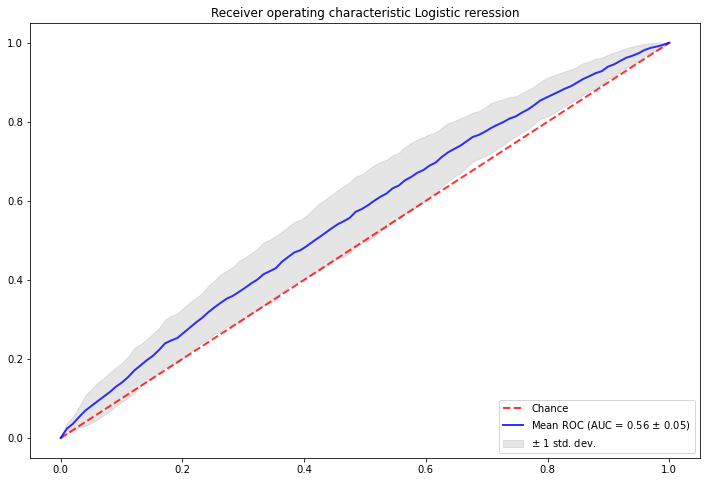

In [494]:
random_state = np.random.RandomState(0)
from sklearn.metrics import auc
#tprs = list(compress(tprs_f[0], results_all[0][:,3]>0.5))
tprs = tprs_f[8]
#aucs = list(compress(aucs_f[0], results_all[0][:,3]>0.5))
aucs = aucs_f[8]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic Logistic reression",
)
ax.legend(loc="lower right")
plt.show()

In [495]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'lr_roc_auc_241_242_not_mat_cl.png'), format='png', bbox_inches='tight', dpi=600)

In [626]:
a_lf = []
a_l = coefs_all[2][2, results_all[2][:,5]>0.5,...]
s = a_l[0].shape
for i in range(len(a_l)):
    k = minmax_scale(a_l[i].reshape(2,-1), feature_range=(-1,1), axis=1)
    a_lf.append(k.reshape(s))
fin_ar = np.mean(a_lf, axis=0)

/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhu

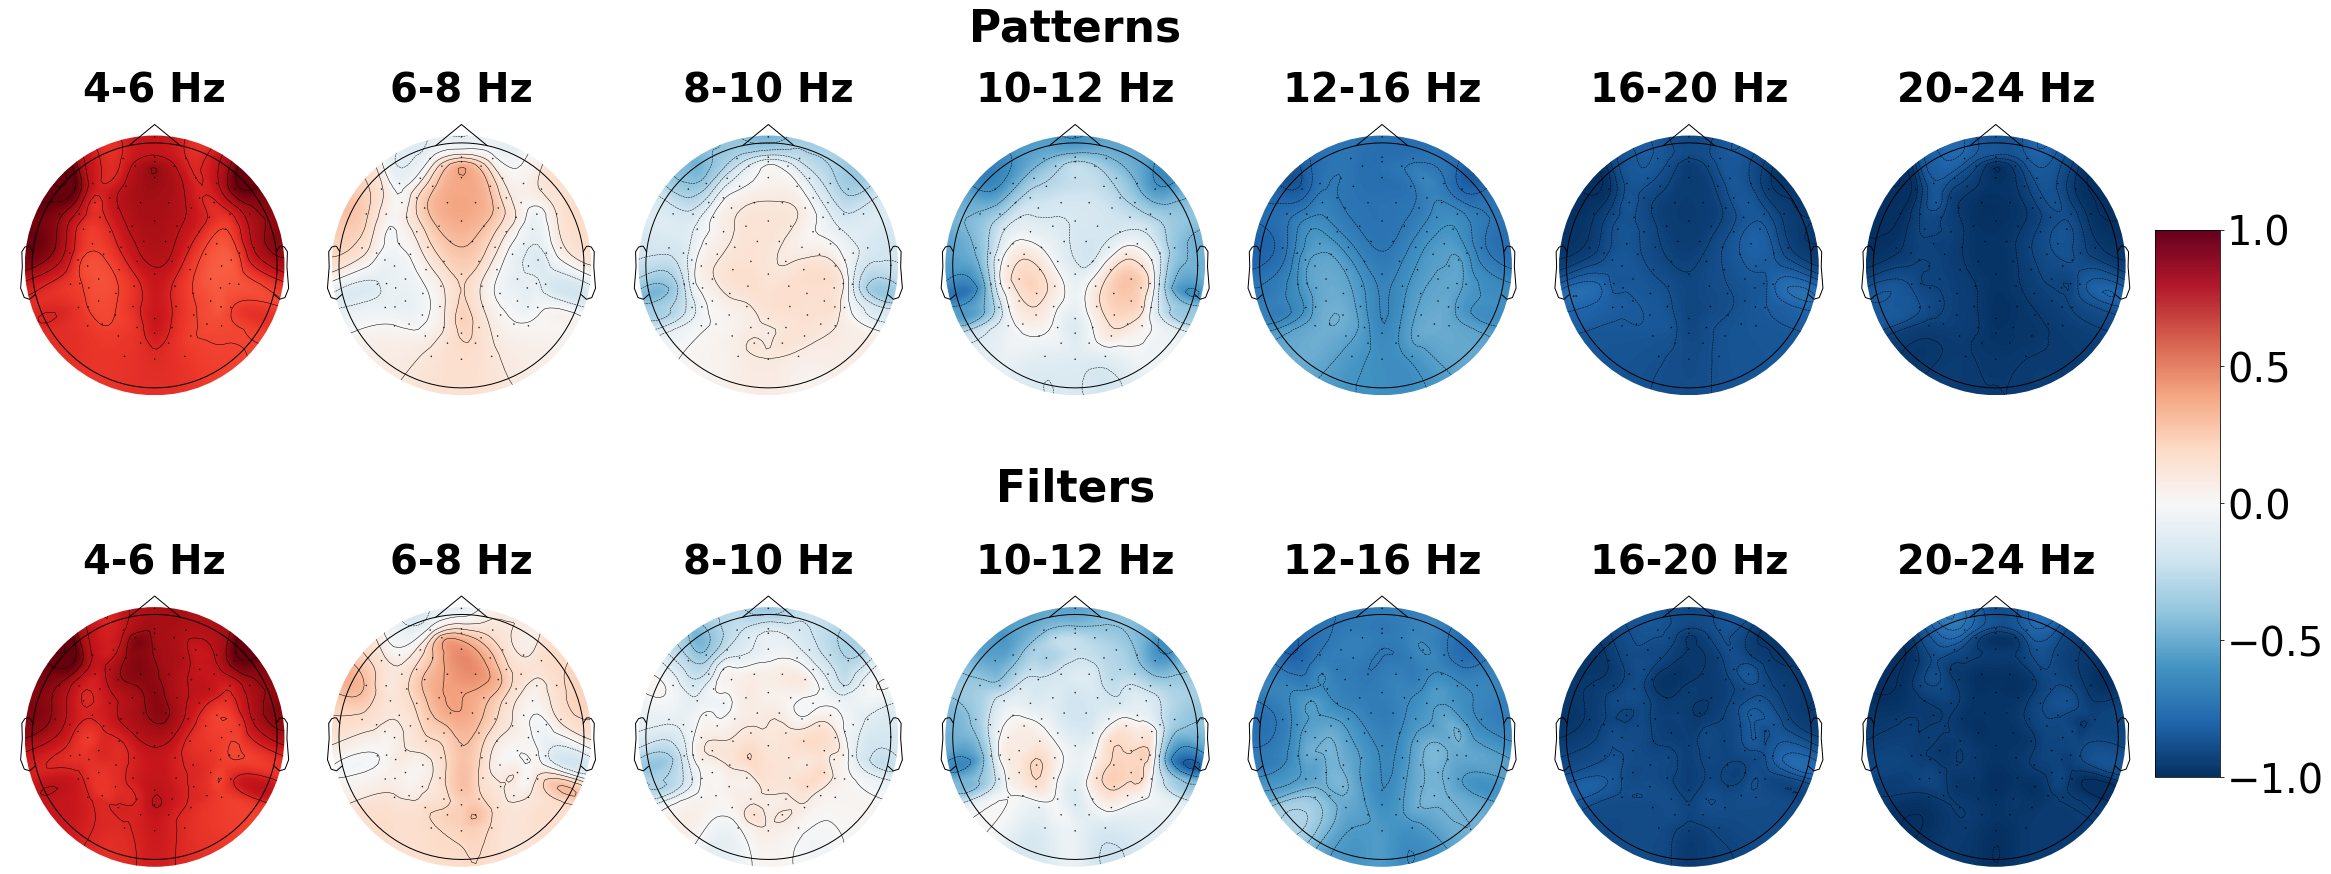

In [627]:
fig = plot_patterns(fin_ar)

In [628]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'feature_patterns_241_242_not_math_cl.png'), format='png', bbox_inches='tight', dpi=600)

In [63]:
# classification using all subjects in both groups and all subjects lgb
index_mat_n, index_not_mat_n = index_mat, index_not_mat
results_all, coefs_all = [], []
list_of_len = [len(indexes), len(index_mat), len(index_not_mat)]

tprs_f, aucs_f = [], []
fpr_f, tpr_f = [], []
im = []
for group_ind, subj_type in enumerate([[*range(len(indexes))],index_mat,index_not_mat]):
    subj_type = np.array(subj_type)
    results_sgroup = np.zeros((list_of_len[group_ind], 6))
    coefs_group_s = np.zeros((len(dict_cls),list_of_len[group_ind],2,len(fr_bands),len(chan1)))
    for i, key in enumerate(list(dict_cls.keys())):
        im1 = []
        ind = dict_cls[key]
        tprs = []
        aucs = []
        fprl = []
        tprl = []
        for count, p in enumerate(subj_type):
            A = np.concatenate(([np.stack([subj_list_features[j] for j in subj_type[subj_type!=p]][it][ind[0]],axis = 1)
                                for it in range((subj_type.shape[0])-1)]),axis=0)
            B = np.concatenate(([np.stack([subj_list_features[j] for j in subj_type[subj_type!=p]][it][ind[1]],axis = 1)
                                for it in range(subj_type.shape[0]-1)]),axis=0)
            C1 = np.stack(subj_list_features[p][ind[0]],axis = 1)
            C2 = np.stack(subj_list_features[p][ind[1]],axis = 1)
            x_train = np.concatenate((A,B),axis=0)
            y_train = [0]*A.shape[0] + [1]*B.shape[0]
            x_test = np.concatenate((C1, C2), axis=0)
            y_test = [0]*C1.shape[0] + [1]*C2.shape[0]
            x_train = x_train.reshape(x_train.shape[0],-1)
            x_test = x_test.reshape(x_test.shape[0],-1)
            x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.1)
            sc = StandardScaler()
            sc.fit(x_train)
            x_train = sc.transform(x_train)
            x_test = sc.transform(x_test)
            lgb = LGBMClassifier(objective='binary')
            lgb.fit(x_train, y_train)
            feature_importances = (lgb.feature_importances_ / sum(lgb.feature_importances_)) * 100
            im1.append(feature_importances)
            predictions = lgb.predict_proba(x_test)
            auc = roc_auc_score(y_test, predictions[:,1])
            ac = balanced_accuracy_score(y_test, lgb.predict(x_test))
            fpr, tpr, _ = roc_curve(y_test, predictions[:,0], pos_label=0)
            fprl.append(predictions)
            tprl.append(y_test)
            roc_auc = metrics.auc(fpr, tpr)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(roc_auc)
            results_sgroup[count, i] = ac
            results_sgroup[count, i+3] = auc
        tpr_f.append(tprl)
        fpr_f.append(fprl)
        tprs_f.append(tprs)
        aucs_f.append(aucs)
        im.append(im1)
    results_all.append(results_sgroup)

In [64]:
df_1 = pd.DataFrame(results_all[0], columns=list_names_subj, index=indexes)
df_2 = pd.DataFrame(results_all[1], columns=list_names_subj, index=index_mat)
df_3 = pd.DataFrame(results_all[2], columns=list_names_subj, index=index_not_mat)
writer = pd.ExcelWriter(os.path.join('/Users/ilyamikheev/Downloads/', 'cross_subjects_classification_tasks_lgb.xlsx'), engine='xlsxwriter')
df_1.to_excel(writer, sheet_name='all_subj')
df_2.to_excel(writer, sheet_name='mat')
df_3.to_excel(writer, sheet_name='not_mat')

writer.save()

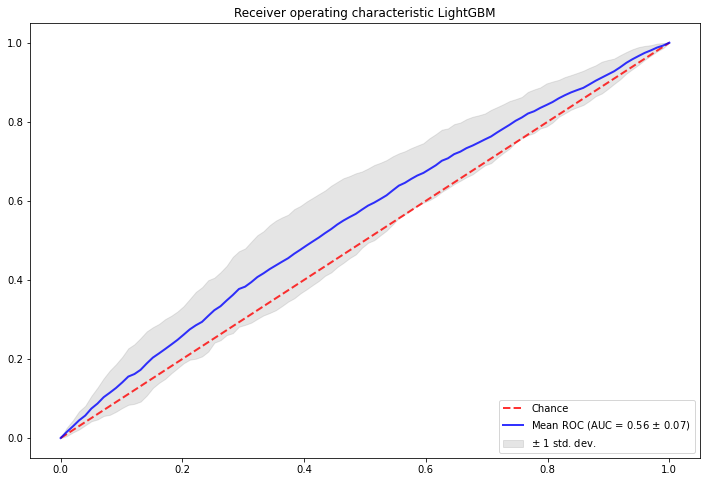

In [577]:
random_state = np.random.RandomState(0)
from sklearn.metrics import auc
#tprs = list(compress(tprs_f[0], results_all[0][:,3]>0.5))
tprs = tprs_f[8]
#aucs = list(compress(aucs_f[0], results_all[0][:,3]>0.5))
aucs = aucs_f[8]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic LightGBM",
)
ax.legend(loc="lower right")
plt.show()

In [580]:
len(im)

9

In [578]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'lgb_roc_auc_241_242_not_math_cl.png'), format='png', bbox_inches='tight', dpi=600)

In [612]:
a_l = list(compress(im[8], results_all[1][:,5]>0.5))
fin_ar = np.mean(a_l, axis=0).reshape((7,95))

/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhu

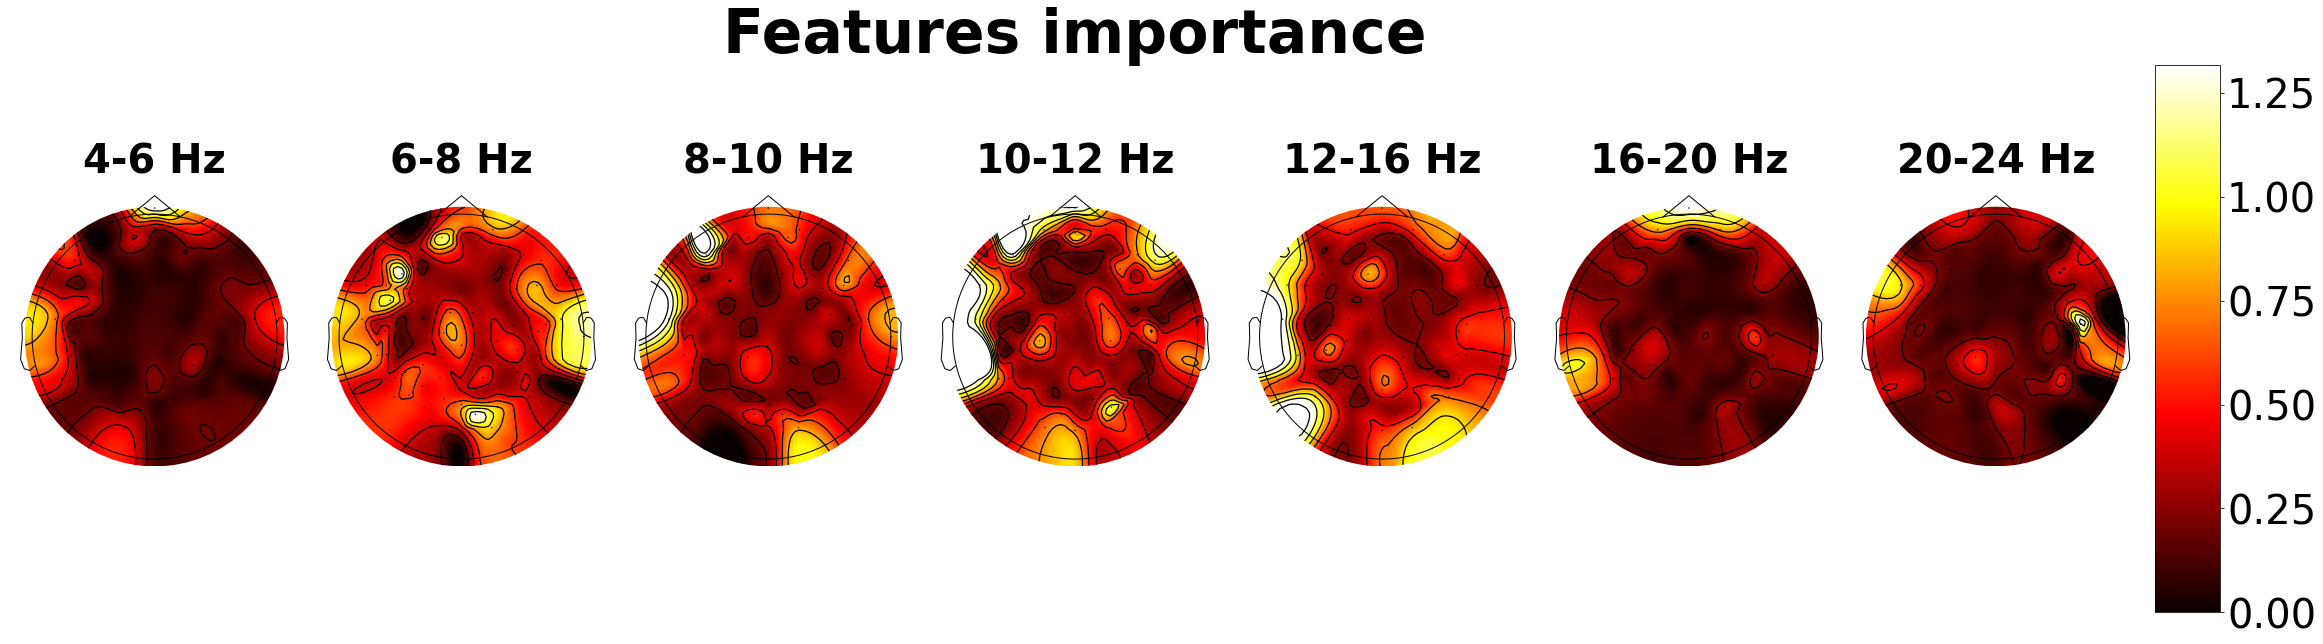

In [613]:
fig = plot_topo(fin_ar, info1)

In [614]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'feature_imp_241_242_not_mat_cl_hot.png'), format='png', bbox_inches='tight', dpi=600)
#plt.save(os.path.join(path_subj_topo, 'cluster_test_244_fin_3.png'), format='png', dpi=600)
plt.close(fig)